<a href="https://colab.research.google.com/github/Staiana/Greenwashing_Project_Group_6/blob/main/REME_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The short-term effect of Greenwashing Accusation on S&P100 companies's stock price
1. Basic Imports
2. Data Cleaning
3. Descriptive Analysis

--> *Exportation on STATA*

# Basic Imports

In [59]:
! pip install yfinance --upgrade --no-cache-dir
! pip install linearmodels



In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns

from tabulate import tabulate
import datetime
import pytz

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
from matplotlib.lines import Line2D

from pandas_datareader import data as pdr
import scipy.stats as st

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import chisquare

from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression
from linearmodels import PanelOLS


#from stargazer.stargazer import Stargazer


In [61]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Data Cleaning


In [62]:
#IMPORT OUR CSV with binary variable for accusation

accusation_data = pd.read_csv('https://raw.githubusercontent.com/Staiana/Greenwashing_Project_Group_6/main/acc_data.csv', delimiter=';')

accusation_data = accusation_data[['Ticker', 'Accusation', 'DATE']]
accusation_data.rename(columns={'DATE': 'Accusation_date'}, inplace=True)

accusation_data['Accusation_date'] = pd.to_datetime(accusation_data['Accusation_date'])

display(accusation_data['Ticker'].unique())
print(len(accusation_data['Ticker'].unique()))

<ipython-input-62-5f717718e238>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  accusation_data['Accusation_date'] = pd.to_datetime(accusation_data['Accusation_date'])


array(['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'AMAT',
       'AMGN', 'AMZN', 'ANET', 'AVGO', 'AXP', 'BA', 'BAC', 'BKNG', 'BLK',
       'BMY', 'BSX', 'BX', 'C', 'CAT', 'CB', 'CI', 'CMCSA', 'COP', 'COST',
       'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'ELV', 'ETN',
       'GE', 'GOOGL', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG',
       'JNJ', 'JPM', 'KLAC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'LRCX',
       'MA', 'MCD', 'MDT', 'META', 'MMC', 'MRK', 'MS', 'MSFT', 'MU',
       'NEE', 'NFLX', 'NKE', 'NOW', 'NVDA', 'ORCL', 'PEP', 'PG', 'PGR',
       'PLD', 'PM', 'QCOM', 'REGN', 'RTX', 'SBUX', 'SCHW', 'SPGI', 'SYK',
       'T', 'TJX', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UBER', 'UNH', 'UNP',
       'UPS', 'V', 'VRTX', 'VZ', 'WFC', 'WMT', 'XOM', 'AIG', 'AMD', 'AMT',
       'BK', 'CHTR', 'CL', 'COF', 'DOW', 'DUK', 'EMR', 'F', 'FDX', 'GD',
       'GILD', 'GM', 'KHC', 'MDLZ', 'MET', 'MMM', 'MO', 'PFE', 'PYPL',
       'SO', 'SPG', 'TGT', 'USB', nan], dtype=object)

125


In [63]:
#retrieve data from yfinance for all dates needed (20 days before/after an accusation)
combined_data = pd.DataFrame()

sp100_tickers = ['AAPL', 'ABBV', 'ABNB', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'AIG',
                 'AMAT', 'AMD', 'AMGN', 'AMT', 'AMZN', 'ANET', 'AVGO', 'AXP', 'BA',
                 'BAC', 'BK', 'BKNG', 'BLK', 'BMY', 'BSX', 'BX', 'C', 'CAT', 'CB',
                 'CHTR', 'CI', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO',
                 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DOW', 'DUK', 'ELV', 'EMR',
                 'ETN', 'F', 'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOGL', 'GS',
                 'HD', 'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KHC',
                 'KLAC', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'LRCX', 'MA', 'MCD',
                 'MDLZ', 'MDT', 'MET', 'META', 'MMC', 'MMM', 'MO', 'MRK', 'MS',
                 'MSFT', 'MU', 'NEE', 'NFLX', 'NKE', 'NOW', 'NVDA', 'ORCL', 'PEP',
                 'PFE', 'PG', 'PGR', 'PLD', 'PM', 'PYPL', 'QCOM', 'REGN', 'RTX',
                 'SBUX', 'SCHW', 'SO', 'SPG', 'SPGI', 'SYK', 'T', 'TGT', 'TJX',
                 'TMO', 'TMUS', 'TSLA', 'TXN', 'UBER', 'UNH', 'UNP', 'UPS', 'USB',
                 'V', 'VRTX', 'VZ', 'WFC', 'WMT', 'XOM']
                                                                                                                #"BRK.B" delete TO ADD IN MISSING VALUES !!!
date_list = []
for date in accusation_data['Accusation_date']:
    if pd.notna(date):                              # Checks if the date is not NaT
        period = pd.date_range(start=date - timedelta(days=100), end=date + timedelta(days=100))
        date_list.extend(period)


date_list = list(set(date_list))
date_list.sort()                         # Now, date_list contains all unique dates 100 days before and after each accusation date
#print(date_list)

for ticker in sp100_tickers:
    stock = yf.Ticker(ticker)

    start_date = min(date_list).strftime('%Y-%m-%d')
    end_date = '2023-12-31'

    # Retrieve historical data for the date range
    history = stock.history(start=start_date, end=end_date)
    info = stock.info # Dictionary of static information
    # Convert static info dictionary to a DataFrame, replicating across all dates in history
    info_df = pd.DataFrame({k: v for k, v in info.items() if not callable(v) and not isinstance(v, (list, dict))}, index=[0]) #Used GPT
    info_df = info_df.loc[info_df.index.repeat(len(history))].reset_index(drop=True)

    # Ensure that history DataFrame index is a column for merging
    history.reset_index(inplace=True)
    history['Date'] = pd.to_datetime(history['Date'])  # Ensure date format is correct
    # Combine historical and info data
    full_data = pd.concat([history, info_df], axis=1)

    # Append to the main combined_data DataFrame
    combined_data = pd.concat([combined_data, full_data], axis=0)
    df_financial_data=combined_data

df_financial_data.reset_index(drop=True, inplace=True)

In [64]:
print(len(df_financial_data['symbol'].unique()))    #nombre companies
df_financial_data.dtypes
df_financial_data.info()
#df_financial_data.columns
df_financial_data.isnull().sum()
df_financial_data['Ticker'] = df_financial_data['symbol']
df_financial_data.set_index('Ticker')
print('.')

124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149794 entries, 0 to 149793
Columns: 142 entries, Date to industrySymbol
dtypes: datetime64[ns, America/New_York](1), float64(76), int64(33), object(32)
memory usage: 162.3+ MB
.




---




Create a DF with only our variables of interest

In [65]:
# clean control data

control_clean = df_financial_data[['Ticker', 'Low','Close','Date', 'Volume', 'Dividends', 'Stock Splits', 'sector','operatingMargins', 'overallRisk','marketCap', 'netIncomeToCommon','ebitda','freeCashflow','enterpriseValue']]
# merge the 2 DF

merged_df = pd.merge(accusation_data, control_clean, on='Ticker', how='inner')
merged_df['Accusation_date'] = merged_df['Accusation_date'].dt.strftime('%d/%m/%Y')
merged_df['Date'] = pd.to_datetime(merged_df['Date']).dt.tz_localize(None)
merged_df['Accusation_date'] = pd.to_datetime(merged_df['Accusation_date']).dt.tz_localize(None)

## DUMMIES

# for day of the week
merged_df = pd.concat([
    merged_df,
    pd.get_dummies(merged_df['Date'].dt.day_name(), prefix='Day')
], axis=1)

ANOVA_df=merged_df[:]
merged_df = pd.get_dummies(merged_df, columns=['sector'])
merged_df['Accusation'] = merged_df['Accusation'].astype(bool)

<ipython-input-65-d7b06713be2c>:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  merged_df['Accusation_date'] = pd.to_datetime(merged_df['Accusation_date']).dt.tz_localize(None)


In [66]:
#function that creates the Pre-Post_accusation (binary variable 1=post and 0=pre)

def pre_post_accusation(row):
    if row['Date'] >= row['Accusation_date']:
        return 1  # Post-accusation
    else:
        return 0  # Pre-accusation

# Apply the function across rows
merged_df['Pre_Post_Accusation'] = merged_df.apply(pre_post_accusation, axis=1)
merged_df.describe()

,Accusation_date,Low,Close,Date,Volume,Dividends,Stock Splits,operatingMargins,overallRisk,marketCap,netIncomeToCommon,ebitda,freeCashflow,enterpriseValue,Pre_Post_Accusation
count,58126,149794.000000,149794.000000,149794,1.497940e+05,149794.000000,149794.000000,149794.000000,149794.000000,1.497940e+05,1.497940e+05,1.352500e+05,1.352500e+05,1.473700e+05,149794.000000
mean,2022-08-04 01:26:08.303340544,175.593202,177.752821,2021-08-05 00:55:19.438695680,1.173849e+07,0.010701,0.000505,0.234073,4.943863,2.871314e+11,9.635010e+09,1.745107e+10,8.504062e+09,2.960040e+11,0.117228
min,2019-06-17 00:00:00,3.322096,3.364042,2019-03-11 00:00:00,9.730000e+04,0.000000,0.000000,-0.056660,1.000000,3.915451e+10,-7.043000e+09,1.516000e+09,-1.984075e+10,-2.264742e+11,0.000000
25%,2022-05-19 00:00:00,59.397216,60.133906,2020-05-22 00:00:00,2.281500e+06,0.000000,0.000000,0.132300,2.000000,1.018521e+11,3.401000e+09,6.808000e+09,2.832212e+09,1.167417e+11,0.000000
50%,2023-01-02 00:00:00,115.100272,116.546173,2021-08-05 00:00:00,4.708450e+06,0.000000,0.000000,0.221600,5.000000,1.439679e+11,5.608000e+09,1.083700e+10,4.854725e+09,1.579137e+11,0.000000
75%,2023-07-01 00:00:00,212.686360,215.268818,2022-10-17 00:00:00,1.070158e+07,0.000000,0.000000,0.316310,8.000000,2.213342e+11,9.279000e+09,1.668400e+10,1.102738e+10,2.466256e+11,0.000000
max,2024-10-01 00:00:00,3531.143697,3557.545898,2023-12-29 00:00:00,9.140820e+08,15.000000,20.000000,0.665640,10.000000,3.155164e+12,1.003890e+11,1.296290e+11,8.472687e+10,3.181379e+12,1.000000
std,NaN,227.925797,230.804188,NaN,2.272202e+07,0.128796,0.078262,0.140248,3.120056,5.210559e+11,1.527867e+10,2.256031e+10,1.339420e+10,5.275133e+11,0.321692


In [67]:
merged_df.drop(['Day_Monday', 'sector_Basic Materials'], axis=1, inplace=True)

In [68]:
merged_df.columns

Index(['Ticker', 'Accusation', 'Accusation_date', 'Low', 'Close', 'Date',
       'Volume', 'Dividends', 'Stock Splits', 'operatingMargins',
       'overallRisk', 'marketCap', 'netIncomeToCommon', 'ebitda',
       'freeCashflow', 'enterpriseValue', 'Day_Friday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday', 'sector_Communication Services',
       'sector_Consumer Cyclical', 'sector_Consumer Defensive',
       'sector_Energy', 'sector_Financial Services', 'sector_Healthcare',
       'sector_Industrials', 'sector_Real Estate', 'sector_Technology',
       'sector_Utilities', 'Pre_Post_Accusation'],
      dtype='object')

#Descriptive Analysis

* Correlation between variables
* Outliers and Missing Values
* Describe final DataFrame
  * Nb of observations
  * Mean and Std
  * Min and Max
* Data visualisation
* Tests of hypotheses



Text(0.5, 1.0, 'Heatmap of correlations between dataset features')

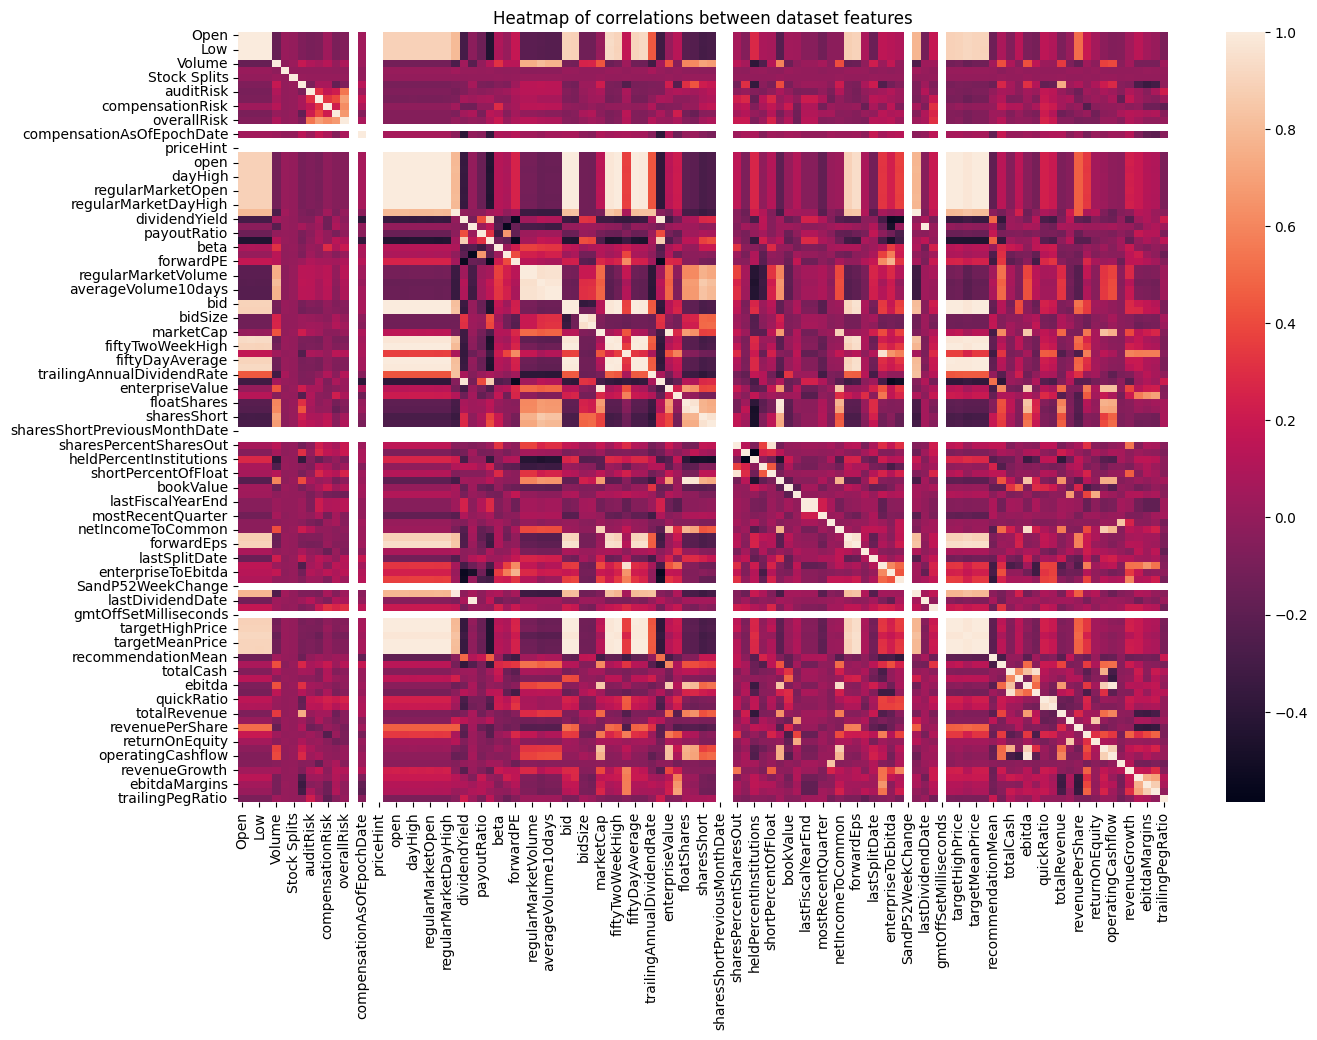

In [69]:
#CORRELATION MAP between control variables           #create a dictionary of all variables that have high correlations, if any and remove the less important one for the regression
df_financial_data.corr(numeric_only=True)
fig=plt.figure(figsize=(15,10))

heat_map_big = df_financial_data.corr(numeric_only=True) #We must ad .corr() here as we are looking for the correlations between our variables.
sb= sns.heatmap(data = heat_map_big)
plt.title('Heatmap of correlations between dataset features')

In [70]:
heat_map_big = heat_map_big.drop(columns=['Low', 'High', 'dayHigh', 'averageVolume10days', 'averageVolume', 'Close'], errors='ignore')

# Get a DataFrame of all correlations greater than 0.5, excluding self-correlations
high_corr_df = (heat_map_big.where(np.triu(np.ones(heat_map_big.shape), k=1).astype(bool))
                 .stack()
                 .reset_index())

high_corr_df = high_corr_df[high_corr_df[0] > 0.56]
high_corr_df = high_corr_df[high_corr_df[0] < 0.95]

high_corr_df.columns = ['Variable1', 'Variable2', 'Correlation']

high_corr_dict = {(row['Variable1'], row['Variable2']): row['Correlation'] for index, row in high_corr_df.iterrows()}


In [71]:
Corr_df= merged_df[:]
Corr_df= Corr_df.drop(['Day_Friday','Day_Wednesday','Day_Tuesday','Day_Thursday', 'sector_Communication Services', 'sector_Consumer Cyclical','sector_Consumer Defensive','sector_Energy','sector_Financial Services','sector_Healthcare','sector_Technology','sector_Industrials','sector_Real Estate','sector_Utilities', 'Pre_Post_Accusation'], axis=1, inplace=False)


Text(0.5, 1.0, 'Heatmap of correlations between our interest variables')

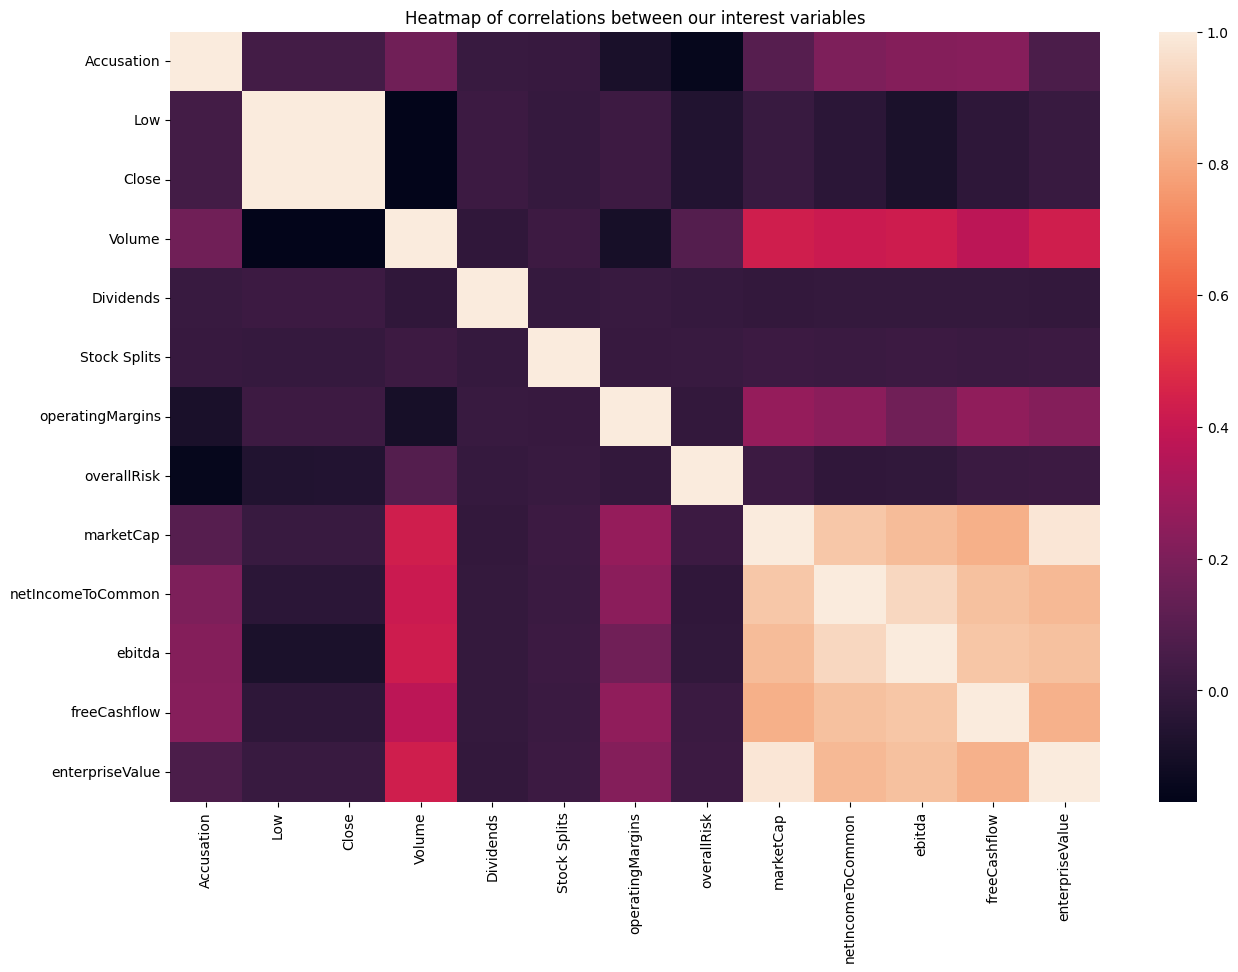

In [72]:
#CORRELATION MAP between control variables           #create a dictionary of all variables that have high correlations, if any and remove the less important one for the regression
fig=plt.figure(figsize=(15,10))
heat_map = Corr_df.corr(numeric_only=True)
sb= sns.heatmap(data = heat_map)
plt.title('Heatmap of correlations between our interest variables')

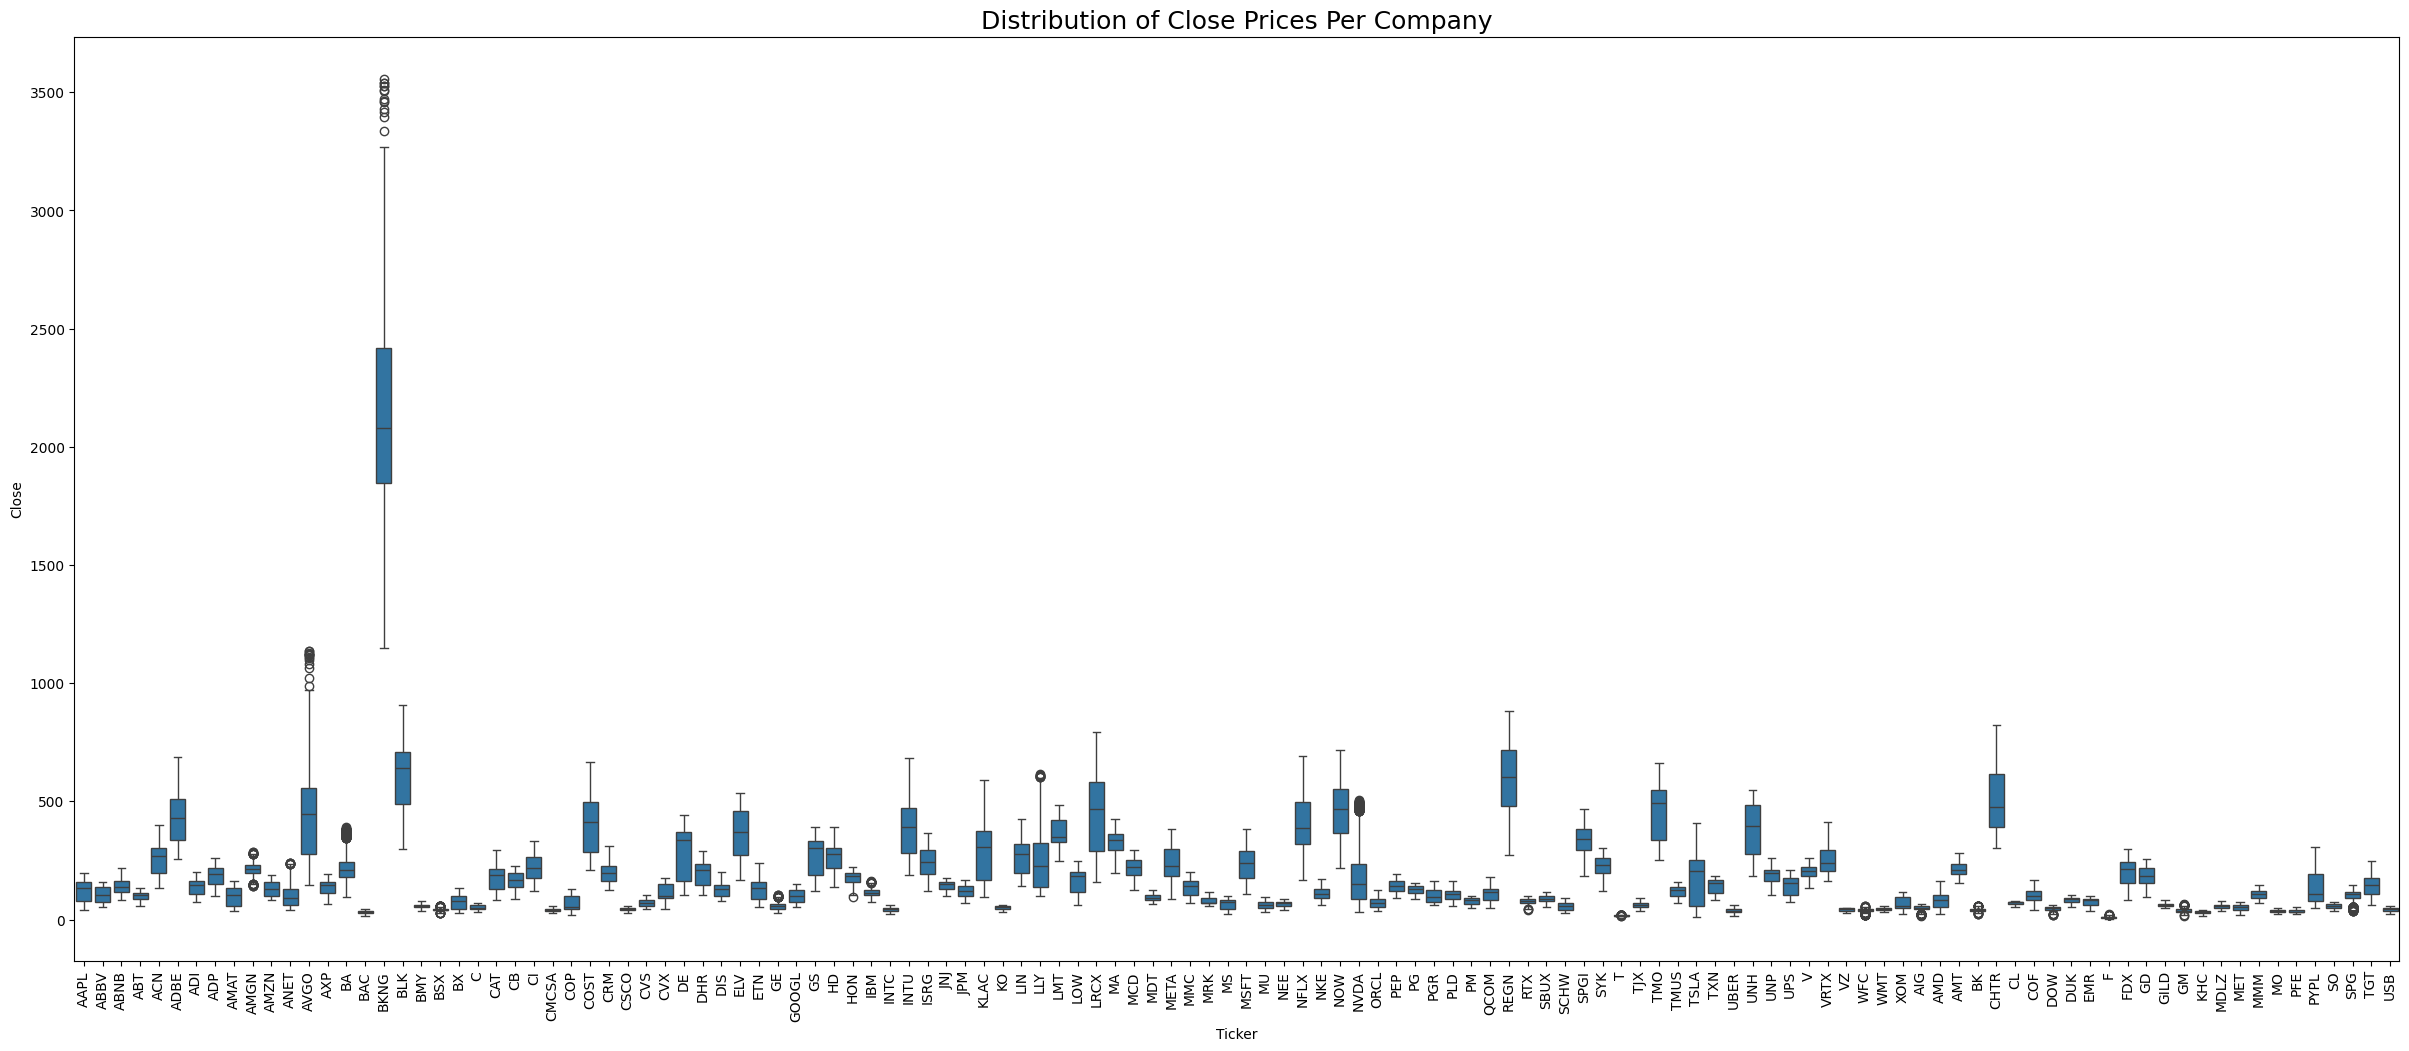

<Figure size 640x480 with 0 Axes>

In [73]:
plt.figure(figsize=(30, 12))  # Set the figure size
sns.boxplot(x='Ticker', y='Close', data=merged_df)
plt.xticks(rotation=90)
plt.title('Distribution of Close Prices Per Company', size=18)
plt.show()
plt.savefig('outliers.png')

In [74]:
mean_per_ticker = merged_df.groupby('Ticker')['Close'].mean()

# Calculate the global mean and standard deviation of the 'Open' prices
global_mean = merged_df['Close'].mean()
global_std = merged_df['Close'].std()

# Define what "too far off" means; here we use 2 standard deviations as a threshold
threshold = 2 * global_std

# Identify outlier tickers whose mean 'Open' price is too far from the global mean
outlier_tickers = mean_per_ticker[(mean_per_ticker < (global_mean - threshold)) |
                                  (mean_per_ticker > (global_mean + threshold))].index.tolist()

final_df = merged_df[~merged_df['Ticker'].isin(outlier_tickers)]
final_df = final_df[final_df['Ticker'] != 'AVGO']

final_df = final_df[final_df['Date'] <= pd.Timestamp('2023-12-31')]
final_df = final_df[final_df['Ticker'] != 'UBER']
merged_df = merged_df[merged_df['Date'] <= pd.Timestamp('2023-12-31')]

final_df.reset_index(drop=True, inplace=True)
print(outlier_tickers)


['BKNG']


In [75]:
#IMPORTANT CELL WHAT HAPPENS IN PERU STAYS IN PERU
## add day of week dummies here
final_df['days_from_accusation'] = (final_df['Date'] - final_df['Accusation_date']).dt.days

final_df['Accusation_date'] = pd.to_datetime(final_df['Accusation_date'])

final_df['year'] = final_df['Date'].dt.year
final_df['month'] = final_df['Date'].dt.month

final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.rename(columns={'Stock Splits': 'Stock_split'}, inplace=True)
final_df['logClose'] = np.log(final_df['Close'])

years = pd.get_dummies(final_df['year'], drop_first=True)
final_df = pd.concat([final_df, years], axis = 1)

#final_df['DayOfWeek'] = final_df['Date'].dt.day_name()
#days_week = pd.get_dummies(final_df['DayOfWeek'])
#final_df = pd.concat([final_df, days_week], axis = 1)

for day in range(-30, 30):
   final_df[f'days_from_accusation_{day}'] = (final_df['days_from_accusation'] == day).astype(int)

#We drop the Rating column
#del final_df['year']
#del final_df['DayOfWeek']
# Create dummy variables for each day in the event window


#Have a look at what dummies actually looks like
pd.set_option ('display.max_columns', None)


### Save final_df to csv

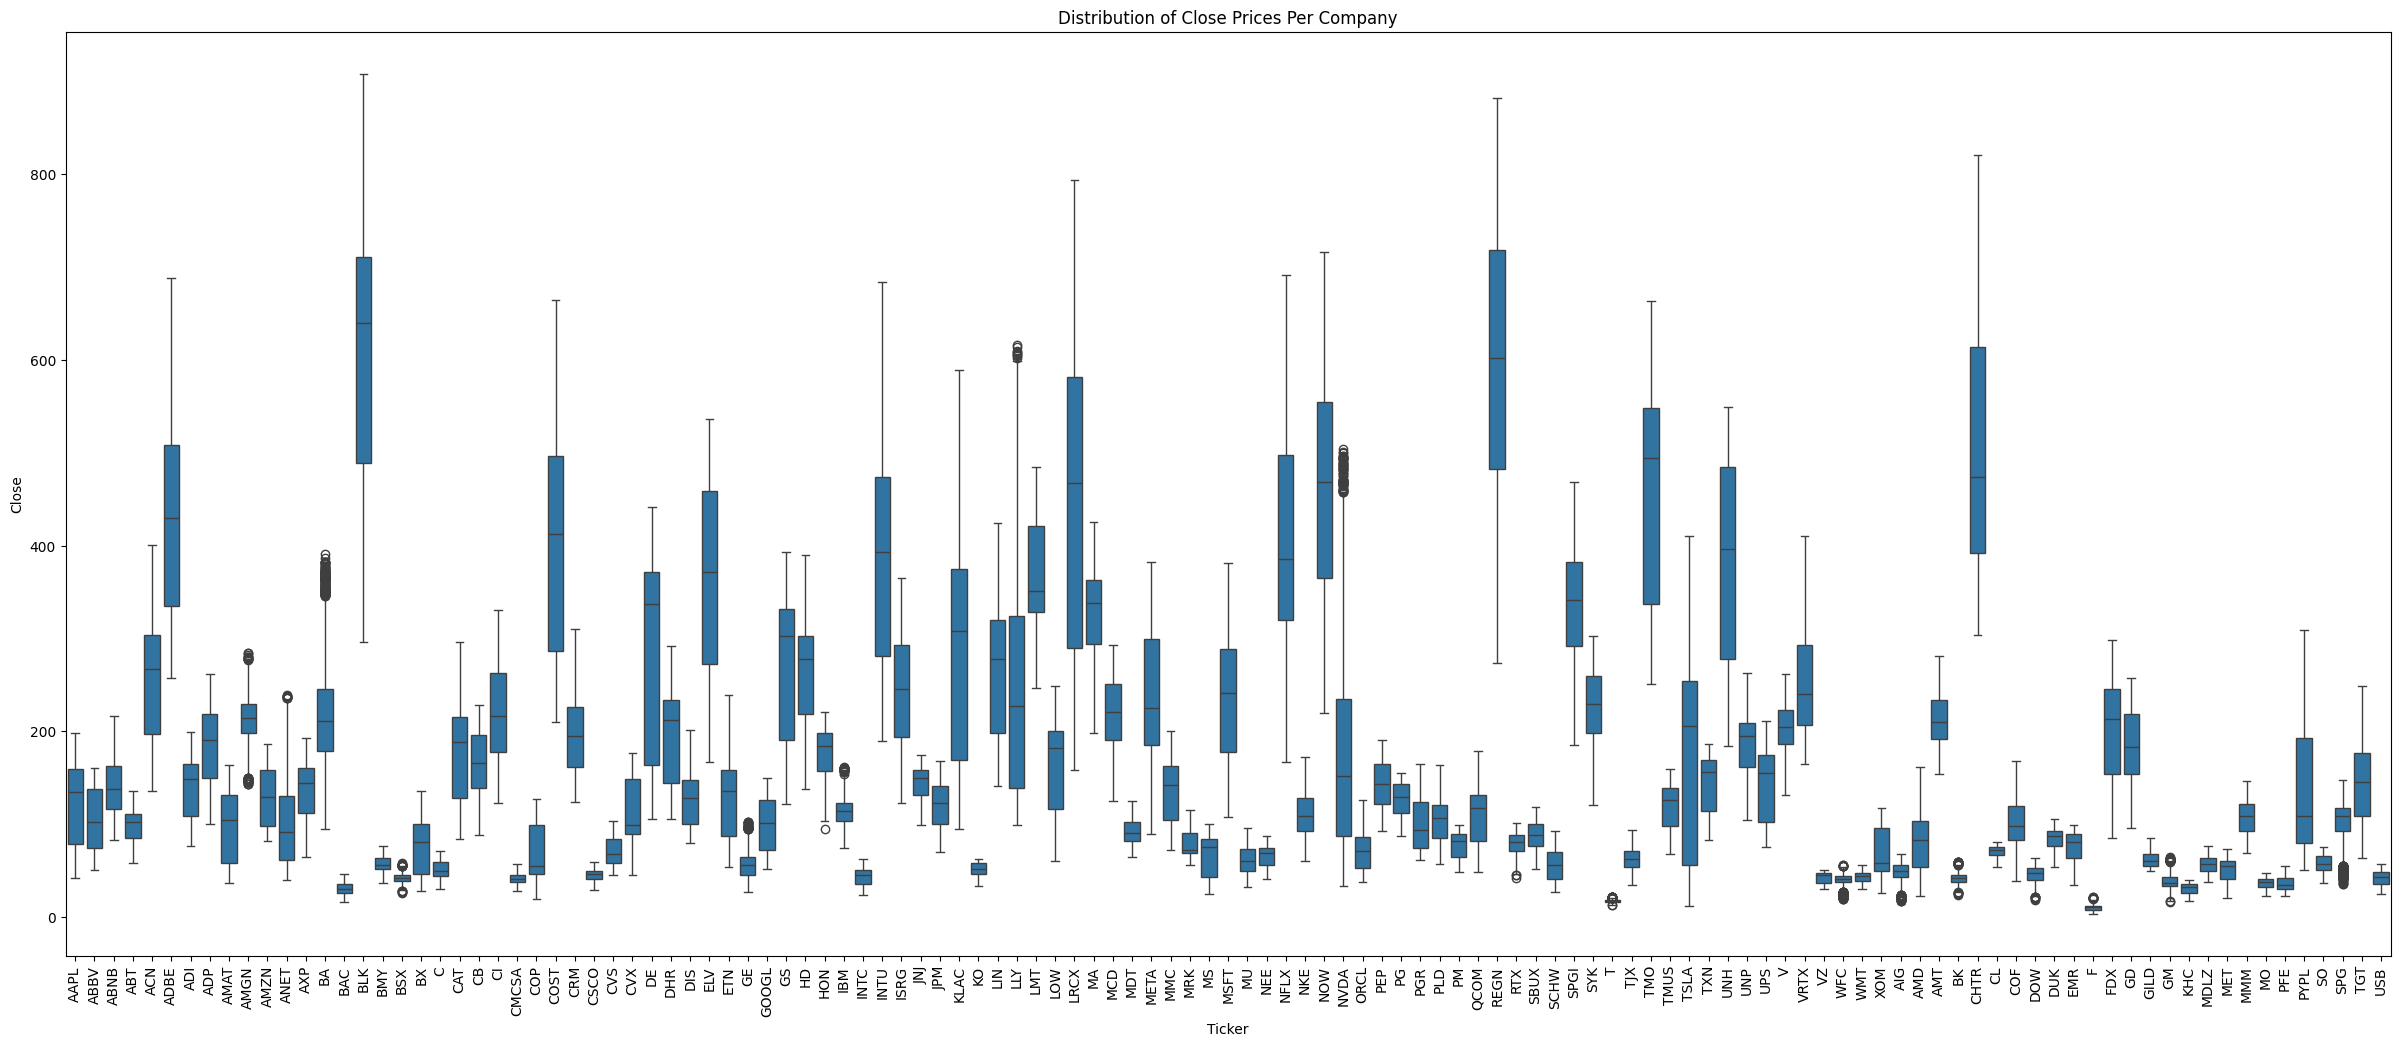

In [76]:
plt.figure(figsize=(30, 12))  # Set the figure size
sns.boxplot(x='Ticker', y='Close', data=final_df)
plt.xticks(rotation=90)
plt.title('Distribution of Close Prices Per Company')
plt.show()

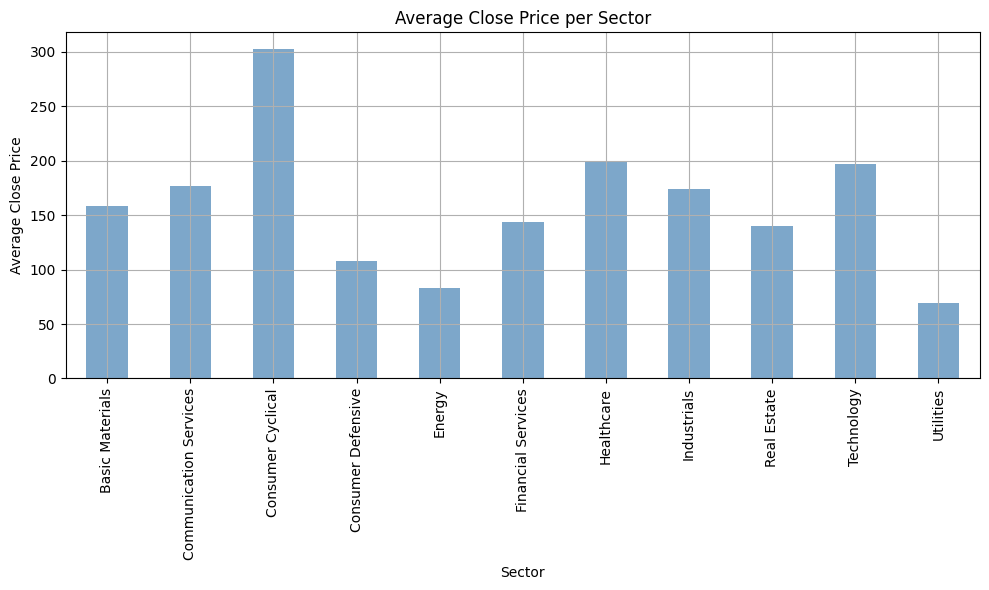

In [77]:
sector_avgs = ANOVA_df.groupby('sector')['Close'].mean()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sector_avgs.plot(kind='bar', color='steelblue', alpha=0.7)
plt.title('Average Close Price per Sector')
plt.xlabel('Sector')
plt.ylabel('Average Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()

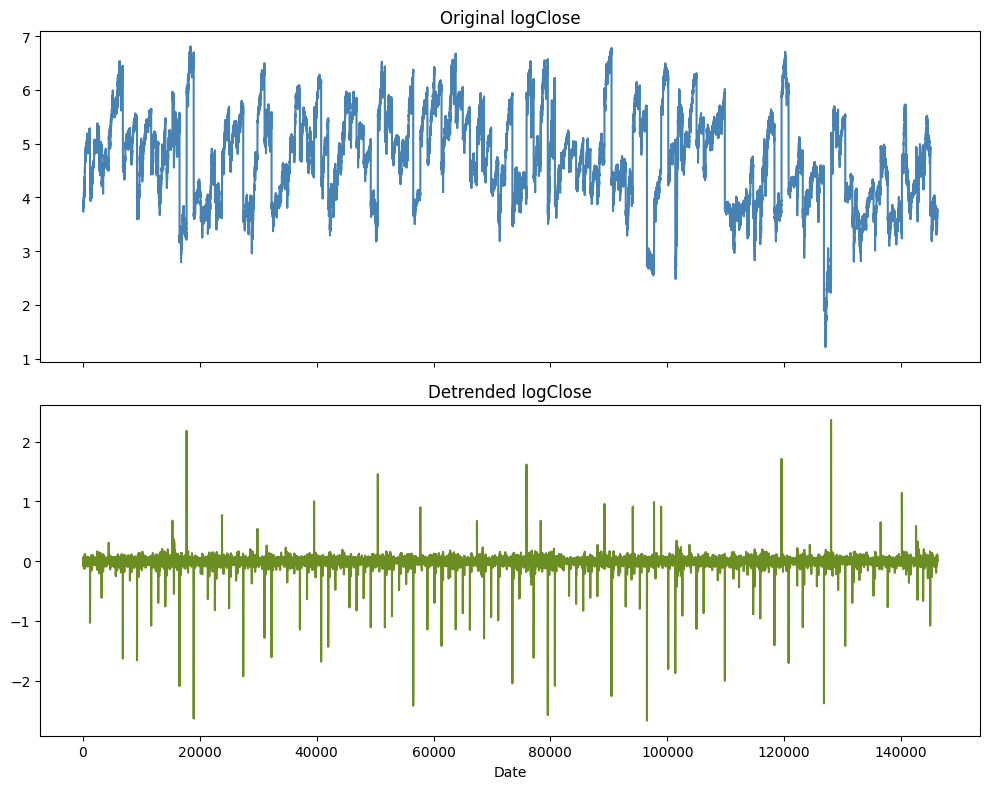

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Detrending using linear regression
final_df['logClose_detrended'] = final_df['logClose'] - final_df['logClose'].rolling(window=10).mean()


# Plotting the results
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

final_df['logClose'].plot(ax=axes[0], color='steelblue', title='Original logClose')
final_df['logClose_detrended'].plot(ax=axes[1], color='olivedrab', title='Detrended logClose')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [79]:
accused_companies = final_df.dropna(subset=['Accusation_date'])  # Companies with an accusation date

# Generate start and end dates for the event window
accused_companies['start_date'] = accused_companies['Accusation_date'] + pd.Timedelta(days=-25)
accused_companies['end_date'] = accused_companies['Accusation_date'] + pd.Timedelta(days=25)

all_relevant_dates = set()  # Start with an empty set for all relevant dates
for index, row in accused_companies.iterrows():
    if pd.notna(row['start_date']) and pd.notna(row['end_date']):
        date_range = pd.date_range(row['start_date'], row['end_date'])
        all_relevant_dates.update(date_range)  # Add current date range to the set
all_relevant_dates = sorted(all_relevant_dates)


# Convert the set of dates to a sorted list if needed, or directly to datetime if required for filtering
all_relevant_dates = pd.to_datetime(list(all_relevant_dates))


# Filter final_df to include all companies during these date ranges
#event_df = final_df[final_df['Date'].isin(all_relevant_dates)]         #old def of event_df taht only looks at periods around
event_df = final_df

In [80]:
event_df['month'] = event_df['month'].astype(float)
event_df.columns = event_df.columns.map(str)

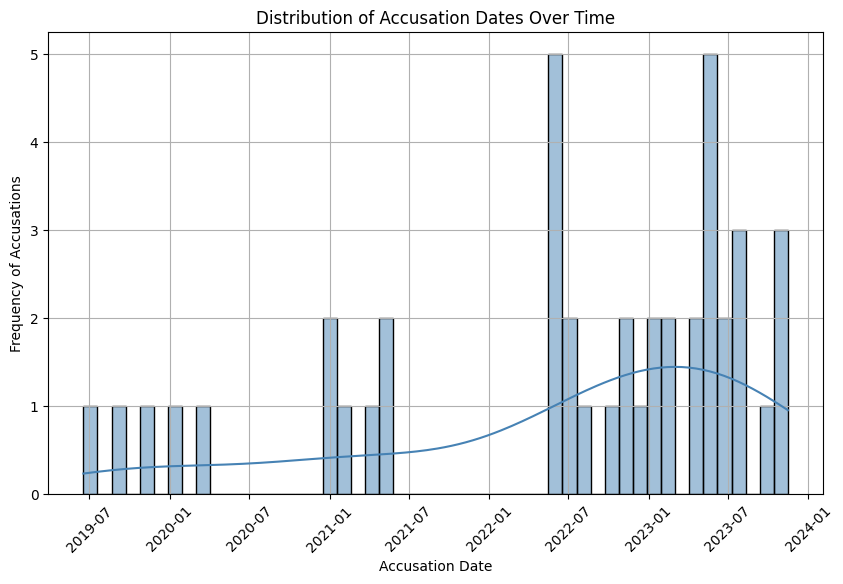

In [81]:
unique_accusations = final_df.drop_duplicates(subset=['Ticker'])
unique_accusations = unique_accusations[unique_accusations['Accusation_date'] < '2024-01-01']

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(unique_accusations['Accusation_date'], kde=True, color='steelblue', bins =50)  # Set kde=True if you want a density plot overlay
plt.title('Distribution of Accusation Dates Over Time')
plt.xlabel('Accusation Date')
plt.ylabel('Frequency of Accusations')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [82]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare

data = {'day_of_year': np.arange(1, 366), 'Number of Accusations': np.random.poisson(lam=10, size=365)}
daily_counts = pd.DataFrame(data)

daily_counts.set_index('day_of_year', inplace=True)
daily_counts = daily_counts.reindex(np.arange(1, 366), fill_value=0)

# Chi-square test for uniform distribution
observed = daily_counts['Number of Accusations'].values
expected = np.full(365, observed.mean())  # Uniform expectation: mean over all days

chi_stat, p_value = chisquare(observed, f_exp=expected)

results_df = pd.DataFrame({
    "Test Statistic": [chi_stat],
    "p-value": [p_value]
})

latex_output = results_df.to_latex(index=False, float_format="{:0.3f}".format)

print(latex_output)

\begin{tabular}{rr}
\toprule
Test Statistic & p-value \\
\midrule
363.367 & 0.500 \\
\bottomrule
\end{tabular}



In [83]:


results_df = pd.DataFrame({
    "Statistic": ["Chi-square Statistic", "P-value"],
    "Value": [f"{chi_stat:.2f}", f"{p_value:.4f}"]
})
display(results_df)


,Statistic,Value
0,Chi-square Statistic,363.37
1,P-value,0.4995


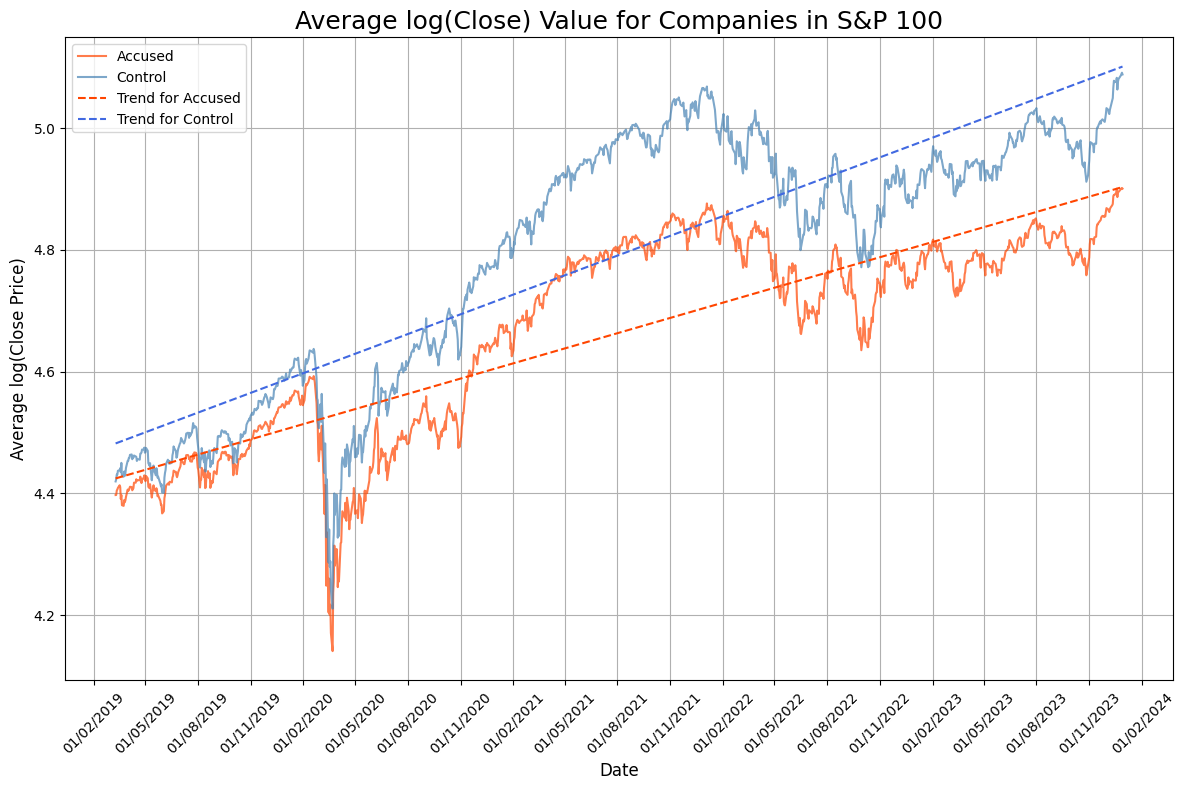

In [84]:

daily_avg_close_1 = final_df[final_df['Accusation'] == 1].groupby('Date')['logClose'].mean().reset_index()
daily_avg_close_0 = final_df[final_df['Accusation'] == 0].groupby('Date')['logClose'].mean().reset_index()

base_date = pd.Timestamp('2000-01-01')
daily_avg_close_1['Days'] = (daily_avg_close_1['Date'] - base_date).dt.days
daily_avg_close_0['Days'] = (daily_avg_close_0['Date'] - base_date).dt.days

model_1 = LinearRegression()
model_1.fit(daily_avg_close_1[['Days']], daily_avg_close_1['logClose'])

model_0 = LinearRegression()
model_0.fit(daily_avg_close_0[['Days']], daily_avg_close_0['logClose'])

line_1 = model_1.predict(daily_avg_close_1[['Days']])
line_0 = model_0.predict(daily_avg_close_0[['Days']])

plt.figure(figsize=(12, 8))

# Scatter plot for Accusation = 1 with smaller marker size
plt.plot(daily_avg_close_1['Date'], daily_avg_close_1['logClose'], color='orangered', label='Accused', alpha=0.7)

# Scatter plot for Accusation = 0
plt.plot(daily_avg_close_0['Date'], daily_avg_close_0['logClose'], color='steelblue', label='Control', alpha=0.7)

# Plot regression lines
plt.plot(daily_avg_close_1['Date'], line_1, color='orangered', linestyle = 'dashed', label='Trend for Accused')
plt.plot(daily_avg_close_0['Date'], line_0, color='royalblue', linestyle = 'dashed', label='Trend for Control')

plt.xlabel('Date', size=12)
plt.ylabel('Average log(Close Price)', size=12)
plt.title('Average log(Close) Value for Companies in S&P 100', size = 18)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

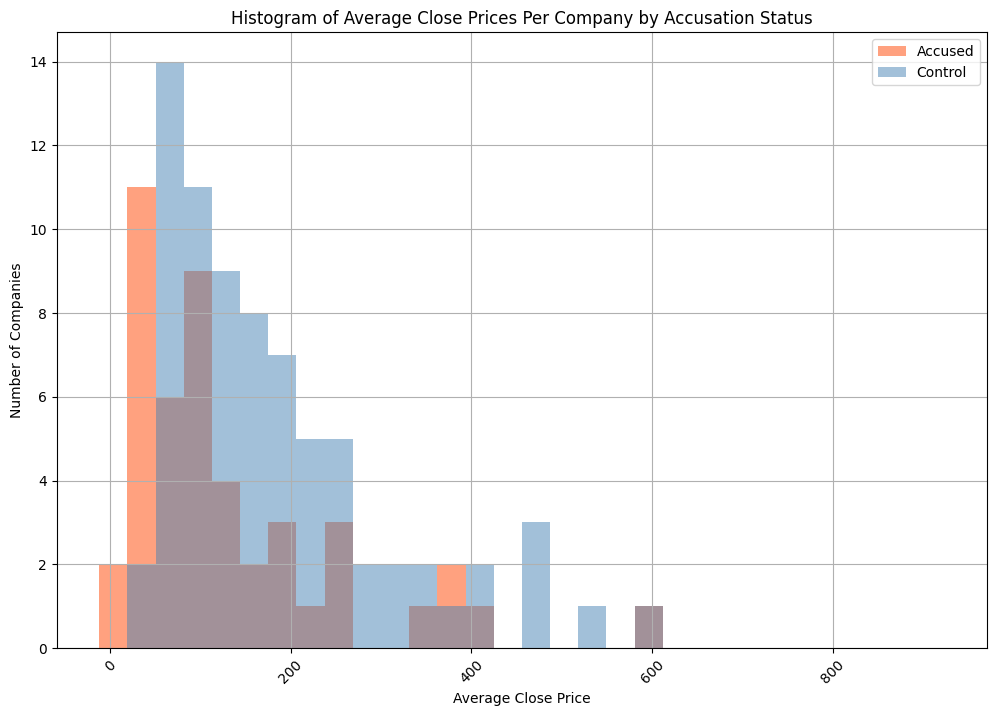

In [85]:
average_close_per_ticker = final_df.groupby(['Ticker', 'Accusation'])['Close'].mean().reset_index()

# Separate the accused and not accused groups
accused = average_close_per_ticker[average_close_per_ticker['Accusation'] == True]
not_accused = average_close_per_ticker[average_close_per_ticker['Accusation'] == False]

bins = np.linspace(min(final_df['Close']), max(final_df['Close']), 30)

plt.figure(figsize=(12, 8))
plt.hist(accused['Close'], bins=bins, color='orangered', alpha=0.5, label='Accused', align='left')
plt.hist(not_accused['Close'], bins=bins, color='steelblue', alpha=0.5, label='Control', align='right')

plt.title('Histogram of Average Close Prices Per Company by Accusation Status')
plt.xlabel('Average Close Price')
plt.ylabel('Number of Companies')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

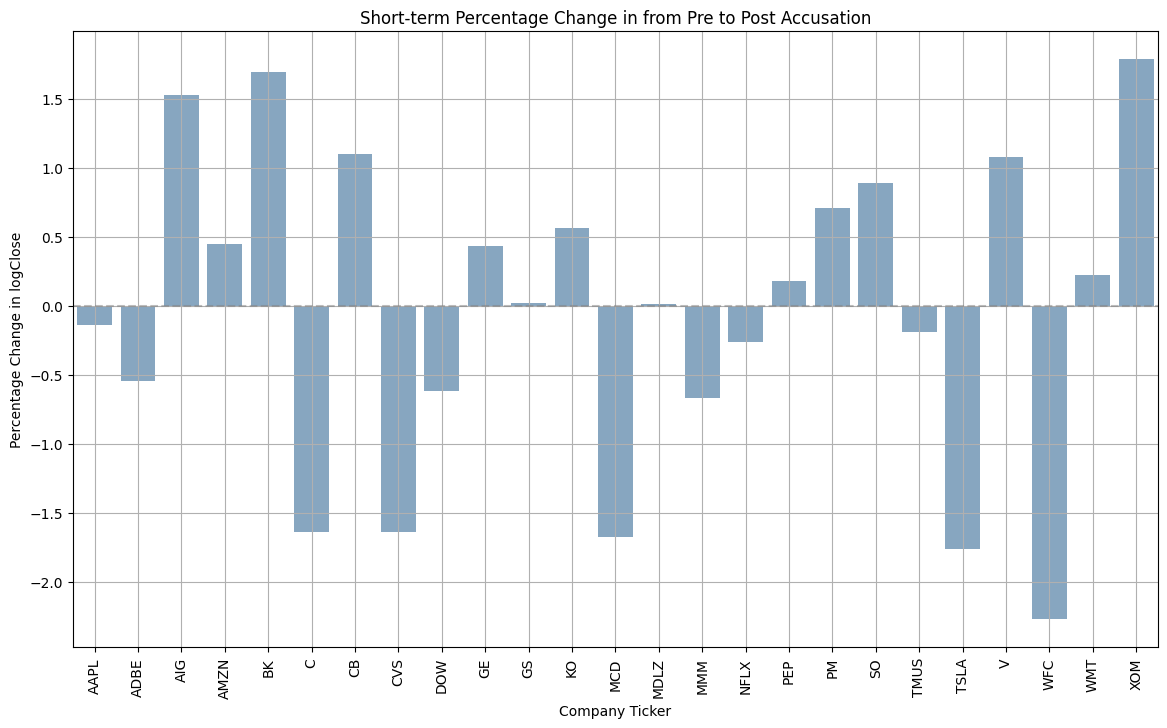

In [86]:
treated_companies = final_df[final_df['Accusation'] == 1]

pre_accusation = treated_companies[(treated_companies['days_from_accusation'] >= -8) & (treated_companies['days_from_accusation'] <= -7)]
post_accusation = treated_companies[(treated_companies['days_from_accusation'] >= 10) & (treated_companies['days_from_accusation'] <= 11)]

avg_pre = pre_accusation.groupby('Ticker')['logClose'].mean().reset_index(name='Pre_Accusation_Mean')
avg_post = post_accusation.groupby('Ticker')['logClose'].mean().reset_index(name='Post_Accusation_Mean')

comparison_df = pd.merge(avg_pre, avg_post, on='Ticker')

comparison_df['Percentage Change'] = (comparison_df['Post_Accusation_Mean'] - comparison_df['Pre_Accusation_Mean']) / comparison_df['Pre_Accusation_Mean'] * 100

plt.figure(figsize=(14, 8))
sns.barplot(x='Ticker', y='Percentage Change', data=comparison_df, color='steelblue', alpha=0.7)
plt.title('Short-term Percentage Change in from Pre to Post Accusation')
plt.xlabel('Company Ticker')
plt.ylabel('Percentage Change in logClose')
plt.xticks(rotation=90)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.grid(True)
plt.show()

## Hypothesis: parallel trends

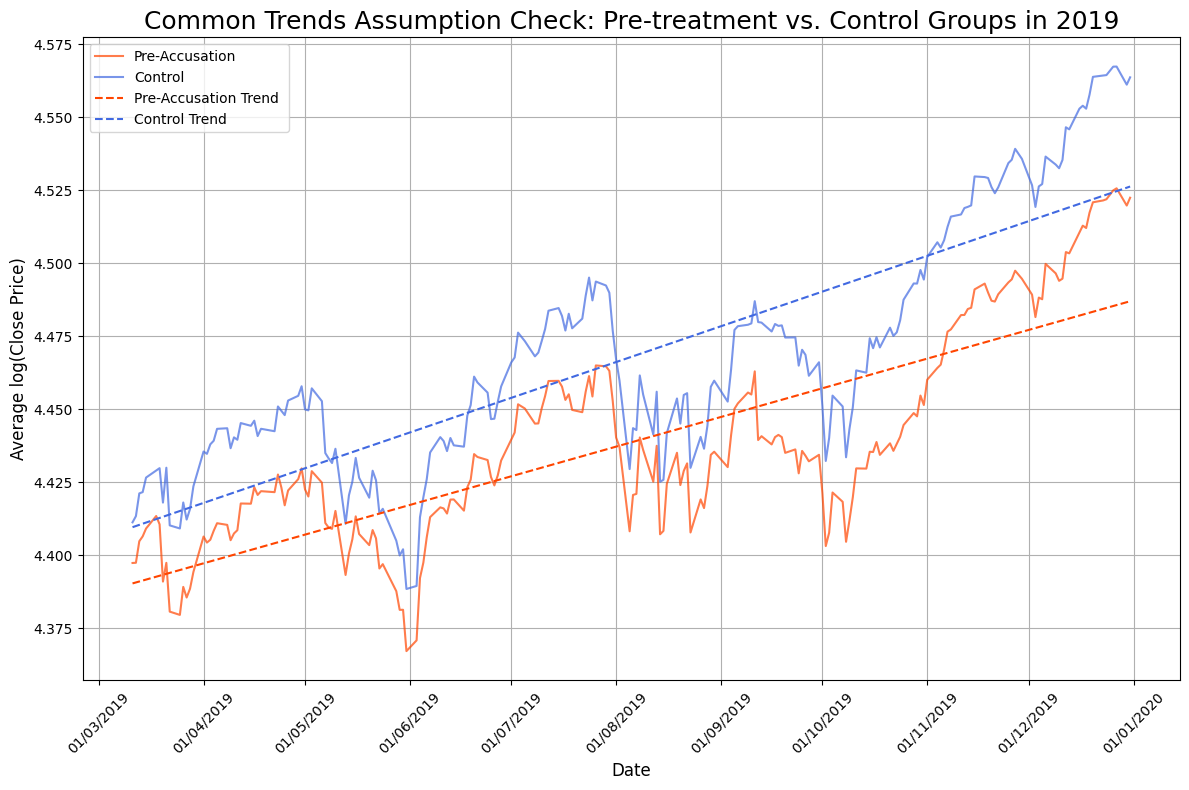

In [87]:
df_2019 = final_df[(final_df['Date'].dt.year == 2019)]
pre_treated = df_2019[(df_2019['Accusation'] == 1) & (df_2019['Pre_Post_Accusation'] == 0)]

# Never treated: Those who are never accused or treated throughout the dataset
never_treated = df_2019[df_2019['Pre_Post_Accusation'] == 0]
avg_pre_treated = pre_treated.groupby('Date')['logClose'].mean().reset_index()
avg_never_treated = never_treated.groupby('Date')['logClose'].mean().reset_index()


combined_data = pd.concat([avg_pre_treated, avg_never_treated])
combined_data['Date_ordinal'] = combined_data['Date'].apply(lambda date: date.toordinal())


plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='logClose', data=avg_pre_treated, label='Pre-Accusation', color='orangered', alpha=0.7)
sns.lineplot(x='Date', y='logClose', data=avg_never_treated, label='Control', color='royalblue', alpha=0.7)



x_pre = avg_pre_treated['Date'].apply(lambda date: date.toordinal())
y_pre = avg_pre_treated['logClose']
x_pre_const = sm.add_constant(x_pre)  # adding a constant for the intercept
model_pre = sm.OLS(y_pre, x_pre_const).fit()
plt.plot(avg_pre_treated['Date'], model_pre.predict(x_pre_const), color='orangered', linestyle = 'dashed', label='Pre-Accusation Trend ')


x_never = avg_never_treated['Date'].apply(lambda date: date.toordinal())
y_never = avg_never_treated['logClose']
x_never_const = sm.add_constant(x_never)  # adding a constant for the intercept
model_never = sm.OLS(y_never, x_never_const).fit()
plt.plot(avg_never_treated['Date'], model_never.predict(x_never_const), color='royalblue', linestyle = 'dashed', label='Control Trend ')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.grid(True)

plt.title('Common Trends Assumption Check: Pre-treatment vs. Control Groups in 2019', size=18)
plt.xlabel('Date', size=12)
plt.ylabel('Average log(Close Price)', size=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
slope_pre = model_pre.params[1]
se_pre = model_pre.bse[1]

slope_never = model_never.params[1]
se_never = model_never.bse[1]

# Calculate the test statistic for equality of slopes (t-test)
# H0: slope_pre - slope_never = 0
# Compute difference in slopes and standard error of the difference
diff_slopes = slope_pre - slope_never
diff_se = np.sqrt(se_pre**2 + se_never**2)  # Assuming independence between samples

# t-statistic for the difference
t_stat = diff_slopes / diff_se

# Degrees of freedom approximately equal to smaller of the two sample sizes minus 2
df = min(len(avg_pre_treated), len(avg_never_treated)) - 2

# p-value from t-distribution
from scipy.stats import t
p_value = (1 - t.cdf(np.abs(t_stat), df)) * 2  # Two-tailed test

print("T-statistic:", t_stat)
print("P-value:", p_value)
data = {
    "Hypothesis": ["Equality of Slopes between Pre-Treated and Control Groups"],
    "T-Statistic": [t_stat],
    "P-Value": [p_value]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame to ensure it looks correct
display(results_df)



T-statistic: -2.6711354986527183
P-value: 0.008169627121857426


,Hypothesis,T-Statistic,P-Value
0,Equality of Slopes between Pre-Treated and Con...,-2.671135,0.00817


In [89]:
n=20
end=n
beginning=-n

In [90]:
event_df_graph= event_df
event_df_graph['Day_Friday'] = event_df_graph['Day_Friday'].astype(int)
event_df_graph['Day_Thursday'] = event_df_graph['Day_Thursday'].astype(int)
event_df_graph['Day_Tuesday'] = event_df_graph['Day_Tuesday'].astype(int)
event_df_graph['Day_Wednesday'] = event_df_graph['Day_Wednesday'].astype(int)


In [91]:
X = sm.add_constant(event_df_graph[['Day_Friday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']])
y = event_df_graph['logClose']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the predicted values (fitted values) from the model
event_df_graph['predicted_logClose'] = model.predict(X)

# Subtract the predicted values from the actual logClose values to get the detrended logClose
event_df_graph['log_Close_week'] = event_df_graph['logClose'] - event_df_graph['predicted_logClose']

# Drop the predicted column if no longer needed
event_df_graph.drop('predicted_logClose', axis=1, inplace=True)


event_df_graph = event_df_graph.reset_index()



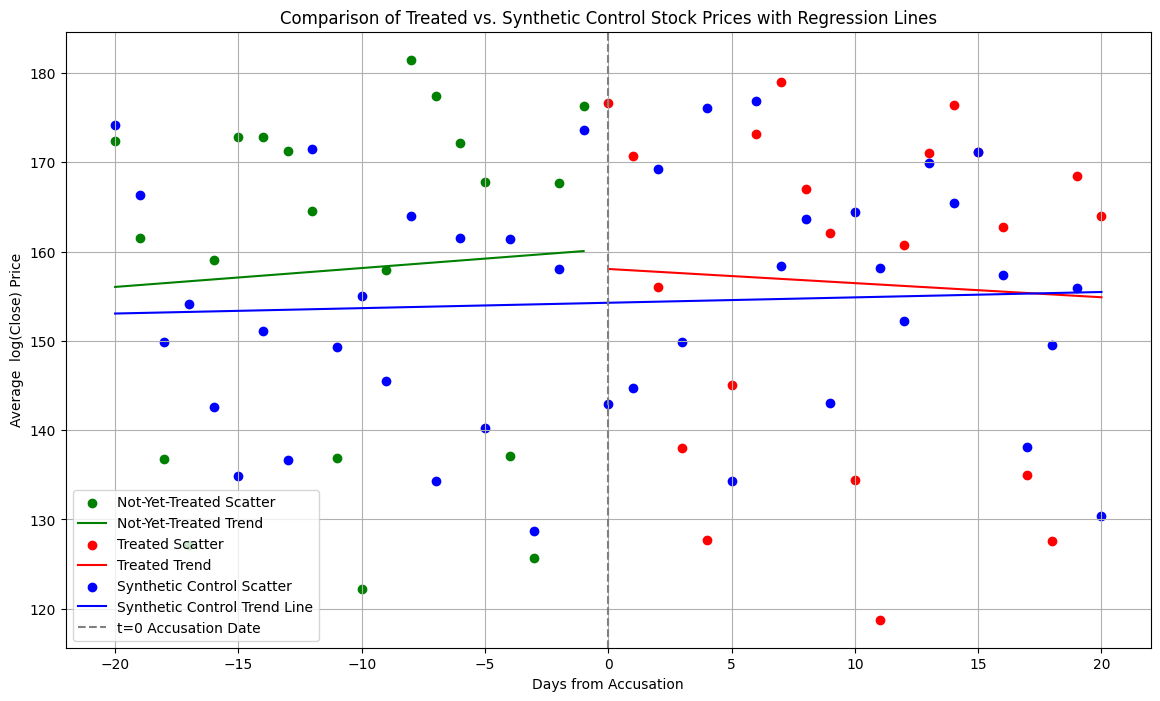

In [92]:
is_treated = event_df_graph['Ticker'][event_df_graph['Pre_Post_Accusation'] == 1].unique()
treated = event_df_graph[event_df_graph['Ticker'].isin(is_treated)]

# Assuming 'Accusation_date' is available and correctly set for when they switch to treated
treated['Date'] = pd.to_datetime(treated['Date'])
treated['Accusation_date'] = pd.to_datetime(treated['Accusation_date'])
treated['days_from_accusation'] = (treated['Date'] - treated['Accusation_date']).dt.days

# Filter data 30 days before and after accusation
treated_window = treated[(treated['days_from_accusation'] >= beginning) & (treated['days_from_accusation'] <= end)]

# Calculate average daily prices for the treated group
treated_avg_logClose = treated_window.groupby('days_from_accusation').agg({'Close': 'mean'}).reset_index()


never_treated = event_df_graph[(event_df_graph['Pre_Post_Accusation'] == 0)]

# Randomly assign synthetic accusation dates within the 2019-2024 range
np.random.seed(42)  # for reproducibility
random_dates = pd.date_range(start='2019-01-01', end='2024-12-31')
never_treated['synthetic_accusation'] = np.random.choice(random_dates, size=len(never_treated))

# Calculate days from these synthetic accusation dates
never_treated['days_from_accusation'] = (pd.to_datetime(never_treated['Date']) - never_treated['synthetic_accusation']).dt.days

# Filter and average similarly
synthetic_window = never_treated[(never_treated['days_from_accusation'] >= beginning) & (never_treated['days_from_accusation'] <= end)]
synthetic_avg_logClose = synthetic_window.groupby('days_from_accusation').agg({'Close': 'mean'}).reset_index()



def plot_treated_with_phased_regressions(data, color_not_yet_treated, color_treated):
    # Split data into not-yet-treated (before t=0) and treated (t=0 and after)
    not_yet_treated = data[data['days_from_accusation'] < 0]
    treated = data[data['days_from_accusation'] >= 0]

    # Plotting not-yet-treated phase
    x_nyt = not_yet_treated['days_from_accusation']
    y_nyt = not_yet_treated['Close']
    plt.scatter(x_nyt, y_nyt, color=color_not_yet_treated, label='Not-Yet-Treated Scatter')
    if not x_nyt.empty:
        x_const_nyt = sm.add_constant(x_nyt)  # adding a constant for intercept
        model_nyt = sm.OLS(y_nyt, x_const_nyt).fit()
        plt.plot(x_nyt, model_nyt.predict(x_const_nyt), color=color_not_yet_treated, label='Not-Yet-Treated Trend')

    # Plotting treated phase
    x_t = treated['days_from_accusation']
    y_t = treated['Close']
    plt.scatter(x_t, y_t, color=color_treated, label='Treated Scatter')
    if not x_t.empty:
        x_const_t = sm.add_constant(x_t)  # adding a constant for intercept
        model_t = sm.OLS(y_t, x_const_t).fit()
        plt.plot(x_t, model_t.predict(x_const_t), color=color_treated, label='Treated Trend')


def plot_with_regression(data, label, color):
    x = data['days_from_accusation']
    y = data['Close']
    plt.scatter(x, y, color=color, label=f'{label} Scatter')

    # Fit and plot regression line
    x_const = sm.add_constant(x)  # adding a constant for the intercept
    model = sm.OLS(y, x_const).fit()
    plt.plot(x, model.predict(x_const), color=color, label=f'{label} Trend Line')

plt.figure(figsize=(14, 8))

# Plotting for treated
plot_treated_with_phased_regressions(treated_avg_logClose, 'green', 'red')

# Repeating similar steps for the synthetic control from the previous setup
# Assume synthetic_avg is prepared as before
plot_with_regression(synthetic_avg_logClose, 'Synthetic Control', 'blue')

plt.axvline(x=0, color='grey', linestyle='--', label='t=0 Accusation Date')
plt.title('Comparison of Treated vs. Synthetic Control Stock Prices with Regression Lines')
plt.xlabel('Days from Accusation')
plt.ylabel('Average  log(Close) Price')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
event_df_graph

,index,Ticker,Accusation,Accusation_date,Low,Close,Date,Volume,Dividends,Stock_split,operatingMargins,overallRisk,marketCap,netIncomeToCommon,ebitda,freeCashflow,enterpriseValue,Day_Friday,Day_Thursday,Day_Tuesday,Day_Wednesday,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Real Estate,sector_Technology,sector_Utilities,Pre_Post_Accusation,days_from_accusation,year,month,logClose,2020,2021,2022,2023,days_from_accusation_-30,days_from_accusation_-29,days_from_accusation_-28,days_from_accusation_-27,days_from_accusation_-26,days_from_accusation_-25,days_from_accusation_-24,days_from_accusation_-23,days_from_accusation_-22,days_from_accusation_-21,days_from_accusation_-20,days_from_accusation_-19,days_from_accusation_-18,days_from_accusation_-17,days_from_accusation_-16,days_from_accusation_-15,days_from_accusation_-14,days_from_accusation_-13,days_from_accusation_-12,days_from_accusation_-11,days_from_accusation_-10,days_from_accusation_-9,days_from_accusation_-8,days_from_accusation_-7,days_from_accusation_-6,days_from_accusation_-5,days_from_accusation_-4,days_from_accusation_-3,days_from_accusation_-2,days_from_accusation_-1,days_from_accusation_0,days_from_accusation_1,days_from_accusation_2,days_from_accusation_3,days_from_accusation_4,days_from_accusation_5,days_from_accusation_6,days_from_accusation_7,days_from_accusation_8,days_from_accusation_9,days_from_accusation_10,days_from_accusation_11,days_from_accusation_12,days_from_accusation_13,days_from_accusation_14,days_from_accusation_15,days_from_accusation_16,days_from_accusation_17,days_from_accusation_18,days_from_accusation_19,days_from_accusation_20,days_from_accusation_21,days_from_accusation_22,days_from_accusation_23,days_from_accusation_24,days_from_accusation_25,days_from_accusation_26,days_from_accusation_27,days_from_accusation_28,days_from_accusation_29,logClose_detrended,log_Close_week
0,0,AAPL,True,2023-10-24,42.145151,42.998386,2019-03-11,128044000,0.00,0.0,0.30743,1,2982175571968,100389003264,1.296290e+11,8.472687e+10,3.019612e+12,0,0,0,0,False,False,False,False,False,False,False,False,True,False,0,-1688.0,2019,3.0,3.761163,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,-0.976756
1,1,AAPL,True,2023-10-24,43.111344,43.481483,2019-03-12,129870400,0.00,0.0,0.30743,1,2982175571968,100389003264,1.296290e+11,8.472687e+10,3.019612e+12,0,0,1,0,False,False,False,False,False,False,False,False,True,False,0,-1687.0,2019,3.0,3.772335,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,-0.970848
2,2,AAPL,True,2023-10-24,43.483890,43.673767,2019-03-13,124130000,0.00,0.0,0.30743,1,2982175571968,100389003264,1.296290e+11,8.472687e+10,3.019612e+12,0,0,0,1,False,False,False,False,False,False,False,False,True,False,0,-1686.0,2019,3.0,3.776748,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,-0.968703
3,3,AAPL,True,2023-10-24,43.878060,44.159267,2019-03-14,94318000,0.00,0.0,0.30743,1,2982175571968,100389003264,1.296290e+11,8.472687e+10,3.019612e+12,0,1,0,0,False,False,False,False,False,False,False,False,True,False,0,-1685.0,2019,3.0,3.787803,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,-0.956491
4,4,AAPL,True,2023-10-24,44.161672,44.733700,2019-03-15,156171600,0.00,0.0,0.30743,1,2982175571968,100389003264,1.296290e+11,8.472687e+10,3.019612e+12,1,0,0,0,False,False,False,False,False,False,False,False,True,False,0,-1684.0,2019,3.0,3.800727,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

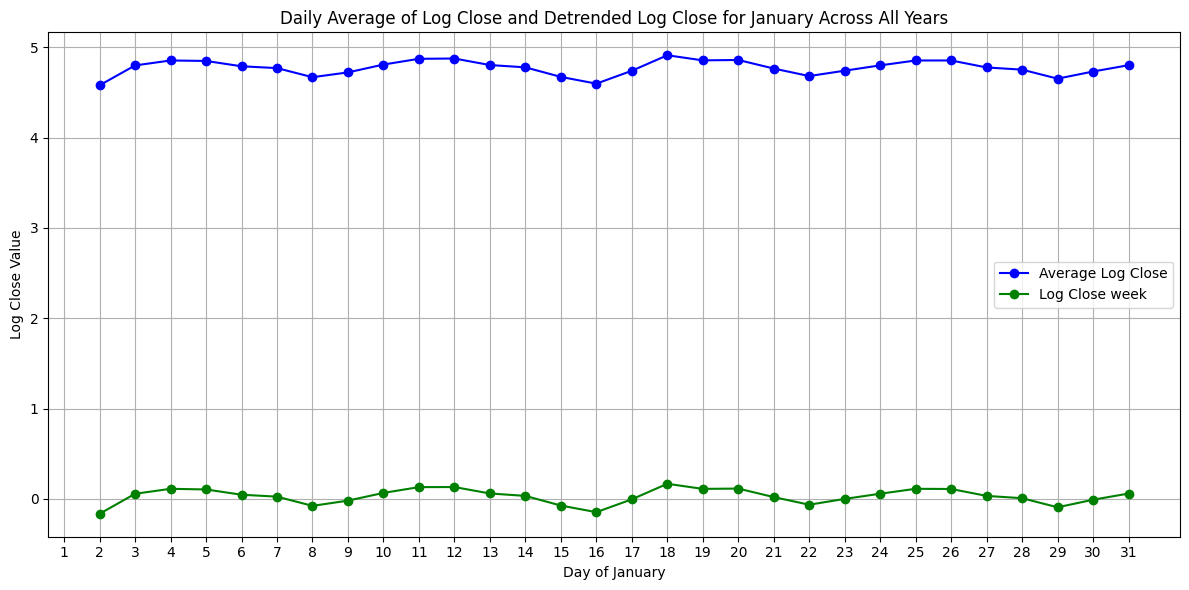

In [96]:
january_data = event_df_graph[event_df_graph['Date'].dt.month == 1]


# Ensure that only numeric columns are included, specifically 'logClose' and 'detrended_logClose'
# Let's first check if these columns are numeric and if not, convert them
january_data['logClose'] = pd.to_numeric(january_data['logClose'], errors='coerce')
january_data['logClose_week'] = pd.to_numeric(january_data['log_Close_week'], errors='coerce')

# Group by day of January to find the mean across all January months for the numeric columns
daily_january_means = january_data[['logClose', 'log_Close_week']].groupby(january_data['Date'].dt.day).mean()

# Create the plot for January
plt.figure(figsize=(12, 6))
plt.plot(daily_january_means.index, daily_january_means['logClose'], label='Average Log Close', color='blue', marker='o')
plt.plot(daily_january_means.index, daily_january_means['log_Close_week'], label='Log Close week', color='green', marker='o')
plt.title('Daily Average of Log Close and Detrended Log Close for January Across All Years')
plt.xlabel('Day of January')
plt.ylabel('Log Close Value')
plt.xticks(range(1, 32))  # Ensure x-ticks for each day of January
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





#-----------------------------
#After cleaning our database and analysing our data, we exported everything to STATA in order to continue with the statistical analysis